In [1]:
from imports import *
from scipy.ndimage import median_filter

In [2]:
global xpix, ypix
xpix, ypix = 1049, 4196

smear_width = 25
overscan_width = 50   # overscan == bias

In [3]:
MAD = lambda x: np.median(abs(x-np.median(x)))

In [48]:
def construct_master_flat(path, kernel_size=49):
    '''
    Construct median filtered flat frames, bias subtract them, and then combine them to create a master flat 
    for each chip on the Tierras detector. 
    '''
    # create and read-in median-filtered flat field images
    #print('Median filtering the individual flat frames...')
    #_median_filter_flats(path, kernel_size=kernel_size)
    fs = np.sort(glob.glob('%s/*FLAT*_medfilt_kernel%i*'%(path,kernel_size)))
    assert fs.size > 0
    
    # construct master flat after normalizing the individual flat frames
    print('Constructing the master flat...')
    master_flat = np.zeros((fs.size, xpix*2, ypix))
    for i,f in enumerate(fs):
        # get flat frame and median-filtered+bias-subtracted flat frame
        frame_str = fs[0].split('.')[1]
        fsv2 = np.sort(glob.glob('%s/*%s.FLAT*fit'%(path,frame_str)))
        assert fsv2.size == 2
        hdu = fits.open(fsv2[0])
        medhdu = fits.open(fsv2[1])

        # median-normalize the flat frame
        master_flat[i,:xpix,:] = hdu[1].data / medhdu[1].data
        master_flat[i,xpix:,:] = hdu[2].data / medhdu[2].data
    
    # modify the output header
    hdu = fits.open(fs[0])
    assert hdu[1].header['NAXIS2'] == xpix
    hdu[1].header['NAXIS2'] = xpix*2
    
    # median combine each median-flattened flat to create the master flat
    hdu0 = fits.PrimaryHDU(header=hdu[0].header)
    hdu1 = fits.ImageHDU(np.nanmedian(master_flat,0), header=hdu[1].header)    
    hdu = fits.HDUList([hdu0, hdu1])
    hdu.writeto('%s/MASTERFLAT_mednorm.fit'%path, overwrite=True)
    
    
    
def _median_filter_flats(path, kernel_size=49):
    '''
    Median filter each individual sky flat and save to a new fits file.
    '''
    # get each chip's scalar bias value
    _,bias1,bias2 = _derive_bias_value(path, verbose=False)

    kernel_size = int(kernel_size+1) if kernel_size % 2 == 0 else int(kernel_size)
    
    # median filter each flat frame
    fs = np.sort(glob.glob('%s/*FLAT*'%path))
    for i,f in enumerate(fs):
        
        if ('medfilt' in f) | ('MASTER' in f):
            continue

        print('%i out of %i (%s)'%(i+1,fs.size,f))
        with fits.open(f) as hdu:
            # convert to float
            img1 = np.copy(hdu[1].data.astype(float))
            img2 = np.copy(hdu[2].data.astype(float))
        
            # trim: set overscan (i.e. bias) and smear regions to NaN
            img1 = _edges_to_nan(hdu, img1)
            img2 = _edges_to_nan(hdu, img2)

            # compute median-filtered flat field if not already done so
            fout = f.replace('.fit','_medfilt_kernel%i.fit'%kernel_size)
            if not os.path.exists(fout):
                # calculate spatial median + trim edges + bias-subtract
                medfilt1 = _edges_to_nan(hdu, median_filter(img1, size=kernel_size)) - bias1
                medfilt2 = _edges_to_nan(hdu, median_filter(img2, size=kernel_size)) - bias2

                # save median-filtered and bias-subtracted image to a new file
                hdu0 = fits.PrimaryHDU(header=hdu[0].header)
                hdu1 = fits.ImageHDU(_edges_to_nan(hdu, medfilt1), header=hdu[1].header)
                hdu2 = fits.ImageHDU(_edges_to_nan(hdu, medfilt2), header=hdu[2].header)
                hdu = fits.HDUList([hdu0, hdu1, hdu2])
                hdu.writeto(fout, overwrite=True)
                


def _edges_to_nan(hdu, img, fill_value=np.nan):
    # mask overscan (i.e. bias) and smear regions
    xind = np.arange(hdu[1].header['NAXIS2'] - smear_width, hdu[1].header['NAXIS2'])
    yind = np.append(np.arange(overscan_width), 
                     np.arange(hdu[1].header['NAXIS1'] - overscan_width, hdu[1].header['NAXIS1']))
    img[xind] = fill_value
    img[:,yind] = fill_value
    return img


        
## get bias value from the bias frames (or from the overscan regions) 
# http://slittlefair.staff.shef.ac.uk/teaching/phy217/lectures/instruments/L12/index.html
def _derive_bias_value(path, verbose=True):
    '''
    Calculate the scalar bias value by averaging the nightly BIAS frames. 
    '''
    
    fs = np.sort(glob.glob('%s/*BIAS*'%path))
    
    out = np.zeros((fs.size,2,4))
    for i,f in enumerate(fs):
        hdu = fits.open(f)
                
        # save stats
        out[i,0,:] = hdu[1].data.mean(), hdu[1].data.std(), np.median(hdu[1].data), MAD(hdu[1].data)
        out[i,1,:] = hdu[2].data.mean(), hdu[2].data.std(), np.median(hdu[2].data), MAD(hdu[2].data)
        
        if verbose:
            print('File: %s'%f)
            print('\tChip 1: mean = %.2f, sd = %.2f, med = %.2f, mad = %.2f'%tuple(out[i,0,:]))
            print('\tChip 2: mean = %.2f, sd = %.2f, med = %.2f, mad = %.2f\n'%tuple(out[i,1,:]))
    
    # return bias value for each chip
    bias1 = np.median(out[:,0,2])
    bias2 = np.median(out[:,1,2])
    
    return out, bias1, bias2

In [49]:
construct_master_flat('incoming/20220331/')

Constructing the master flat...


## diagnostic plots

In [90]:
# get individual median filtered flats
fsmf = np.sort(glob.glob('incoming/20220308/*FLAT*medfilt*'))

# get individual flats
fstmp = np.sort(glob.glob('incoming/20220308/2*FLAT*'))
fs = fstmp[np.in1d(fstmp, fsmf, invert=True)]

assert fs.size*2 == fsmf.size

In [91]:
# normalize each flat
mjd = np.zeros(fs.size)
flats = np.zeros((fs.size,2,xpix,ypix))  # [Nflats, Nchips, Nx, Ny]
for i in range(fs.size):
    # read in flat
    hdu_raw = fits.open(glob.glob('incoming/20220308/*FLAT%.3d.fit'%(i+1))[0])
    mjd[i] = hdu_raw[0].header['MJD-OBS'] - 57e3
    
    # read in filtered flat
    hdu_filt1 = fits.open(glob.glob('incoming/20220308/*FLAT%.3d_kernel49_medfilt1*'%(i+1))[0])
    hdu_filt2 = fits.open(glob.glob('incoming/20220308/*FLAT%.3d_kernel49_medfilt2*'%(i+1))[0])
    
    # normalize the flat by its median
    flats[i,0] = hdu_raw[1].data / hdu_filt1[0].data
    flats[i,1] = hdu_raw[2].data / hdu_filt2[0].data

Text(0, 0.5, 'average of flattened flat over row 2000')

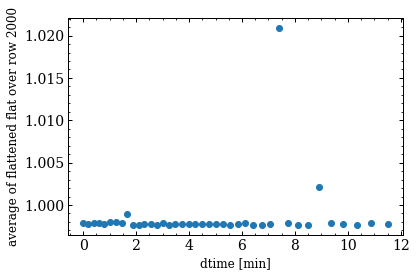

In [92]:
ind = 2000
plt.plot((mjd-mjd[0])*24*60, np.mean(flats[:,0,:,ind],1), 'o')

plt.xlabel('dtime [min]', fontsize=12)
plt.ylabel('average of flattened flat over row %i'%ind, fontsize=12)

In [107]:
mjd.size

40

## look at a flattened science image

In [93]:
img = fits.open('incoming/20220308/20220308.0042.GJ1105.fit')
masterflat1 = fits.open('incoming/20220308/MASTERFLAT1.fit')
masterflat2 = fits.open('incoming/20220308/MASTERFLAT2.fit')

In [106]:
img_clean = np.zeros((2,xpix,ypix))
img_clean[0] = (img[1].data - bias1) / masterflat1[0].data
img_clean[1] = (img[2].data - bias2) / masterflat2[0].data

fits.writeto('incoming/20220308/example_flattened_image.fit', img_clean[0], header=img[0].header, overwrite=1)

<ipython-input-106-c2e5cd889615>:2: RuntimeWarning: divide by zero encountered in true_divide
  img_clean[0] = (img[1].data - bias1) / masterflat1[0].data
<ipython-input-106-c2e5cd889615>:2: RuntimeWarning: invalid value encountered in true_divide
  img_clean[0] = (img[1].data - bias1) / masterflat1[0].data


<ipython-input-102-2a39f8d0a714>:1: RuntimeWarning: divide by zero encountered in log10
  plt.pcolormesh(np.log10(img_clean[0]))
<ipython-input-102-2a39f8d0a714>:1: RuntimeWarning: invalid value encountered in log10
  plt.pcolormesh(np.log10(img_clean[0]))


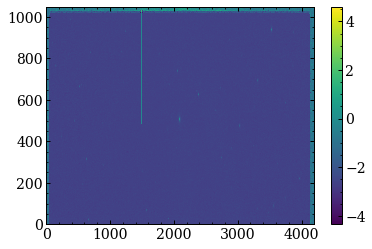

In [102]:
plt.pcolormesh(np.log10(img_clean[0]))
plt.colorbar()